In [1]:
%matplotlib inline
import emcee
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time, math
import torch
from tqdm import tqdm
from torch.multiprocessing import Pool#, set_start_method
from getdist import plots, MCSamples
import pymultinest
import getdist

sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from CovNet import CovNet

In [2]:
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [4]:
cosmo_prior = np.array([[66.5, 75.5],
                        [0.10782, 0.13178],
                        [0.0211375, 0.0233625],
                        [1.1885e-9, 2.031e-9],#[2.4752, 3.7128],
                        [1.806, 2.04],
                        [-2.962, 0.458]])

cosmo_fid = np.array([69,0.1198,0.02225,2e-9,1.4,0.])

gparams = {'logMmin': 13.9383, 'sigma_sq': 0.7918725**2, 'logM1': 14.4857, 'alpha': 1.19196,  'kappa': 0.600692, 
          'poff': 0.0, 'Roff': 2.0, 'alpha_inc': 0., 'logM_inc': 0., 'cM_fac': 1., 'sigv_fac': 1., 'P_shot': 0.}
redshift = 0.5

In [5]:
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
pgg = pkmu_hod()

data_vector = np.concatenate((P_BOSS[1], P_BOSS[2]))

def model_vector(params, gparams):
    """
    Calculates the model vector using Yosuke's galaxy power spectrum emulator
    """
    #print(params)
    h = params[0] / 100
    omch2 = params[1]
    ombh2 = params[2]
    #assert omch2 <= 0.131780
    As = np.log(1e10 * params[3])
    #assert As >= 2.47520
    ns = 0.965
    Om0 = (omch2 + ombh2 + 0.00064) / (h**2)
    
    # rebuild parameters into correct format (ombh2, omch2, 1-Om0, ln As, ns, w)
    cparams = np.array([ombh2, omch2, 1-Om0, As, ns, -1])
    redshift = 0.5
    k = np.linspace(0.005, 0.25, 50)
    mu = np.linspace(0.1,0.9,4)
    alpha_perp = 1.1
    alpha_para = 1

    pgg.set_cosmology(cparams, redshift)
    pgg.set_galaxy(gparams)
    P0_emu = pgg.get_pl_gg_ref(0, k, alpha_perp, alpha_para, name='total')
    P2_emu = pgg.get_pl_gg_ref(2, k, alpha_perp, alpha_para, name='total')
    return np.concatenate((P0_emu, P2_emu))

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [6]:
# load in the mcmc chain from file
N    = 60000
NDIM = 6
#file1 = np.load(data_dir+"mcmc_chains_fixed.npz")
file2 = np.load(data_dir+"mcmc_chains_VAE.npz")
#chain_fixed = file1["chain"]
chain_VAE = file2["chain"]
#rate_fixed = file1["rate"]
rate_VAE = file2["rate"]

In [8]:
# fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
# for i in range(NDIM):
#     ax[i].plot(chain_fixed[:,i].T, 'k-', lw=0.3)
# plt.show()  

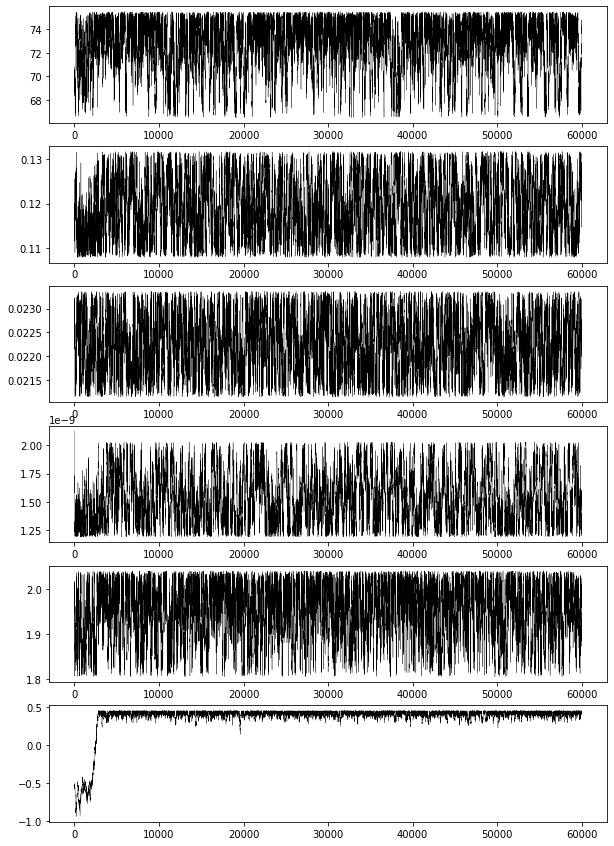

In [9]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
for i in range(NDIM):
    ax[i].plot(chain_VAE[:,i].T, 'k-', lw=0.3)
plt.show()  

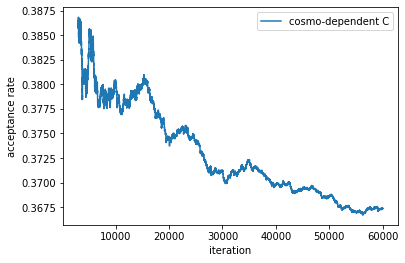

In [10]:
#plt.plot(range(N)[3000:], rate_fixed[3000:], label="fixed C")
plt.plot(range(N)[3000:], rate_VAE[3000:], label="cosmo-dependent C")
plt.xlabel("iteration")
plt.ylabel("acceptance rate")
plt.legend()

In [11]:
N_BURN_IN = 3000

#samples_fixed = chain_fixed[N_BURN_IN:, :].reshape((-1,NDIM))
samples_VAE = chain_VAE[N_BURN_IN:, :].reshape((-1,NDIM))

In [12]:
def plot_cosmo_contours(sample_list_1, sample_list_2, legend_labels, num_plots):
    names = ['H0', 'omegac', 'omegab', 'As', 'b1', 'b2']
    labels =  ["H_0", '\omega_c', '\omega_b', 'A_s', 'b1', 'b2']
    
    #cosmo_truth = [69., 0.1199772, 0.0228528, 2e-9, 1.9485, -0.5386]
    cosmo_truth = [67.8, 0.1190, 0.02215, 2e-9, 2.01, -0.47]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples_1, getdist_samples_2 = [],[]
    label = labels[:num_plots]
    name = names[:num_plots]
    getdist_samples_1 = MCSamples(samples=sample_list_1[:,:num_plots], names = name, labels=label, label=legend_labels[0])
    getdist_samples_2 = MCSamples(samples=sample_list_2[:,:num_plots], names = name, labels=label, label=legend_labels[1])
    
    g = plots.get_subplot_plotter()
    g.triangle_plot([getdist_samples_1, getdist_samples_2], filled=True, markers=truth_dict)
    
    plt.show()

Removed no burn in
Removed no burn in


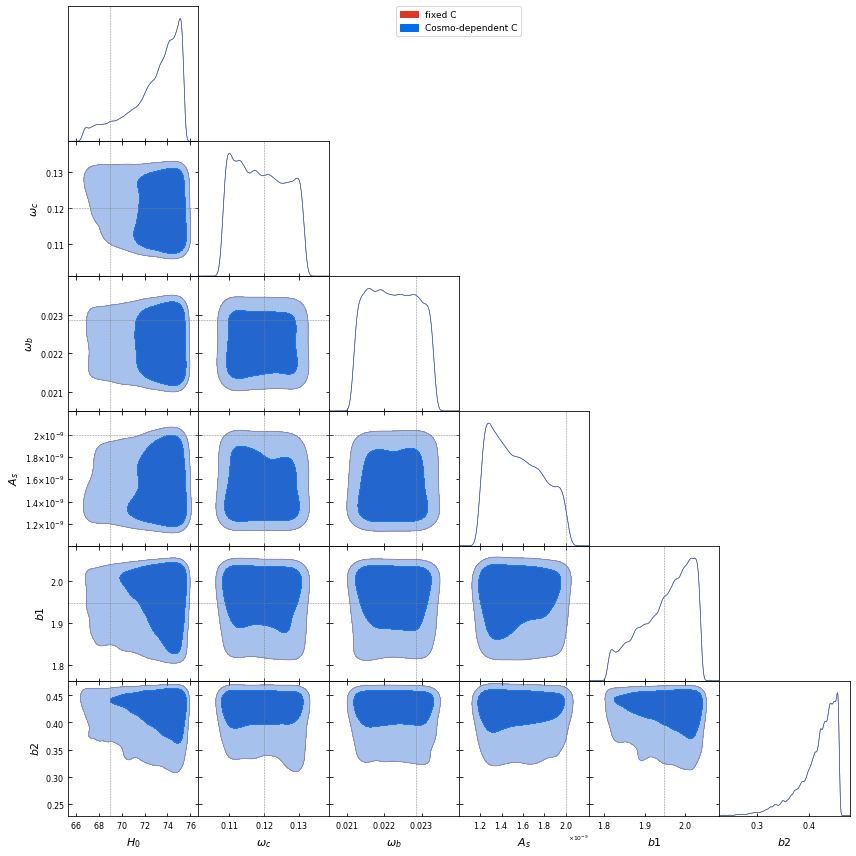

In [13]:
plot_cosmo_contours(samples_VAE, samples_VAE, ['fixed C', "Cosmo-dependent C"], 6)

## MultiNest Code

  analysing data from /home/joeadamo/Research/CovNet/chains/Multinest-.txt
  analysing data from /home/joeadamo/Research/CovNet/chains/Varied-.txt


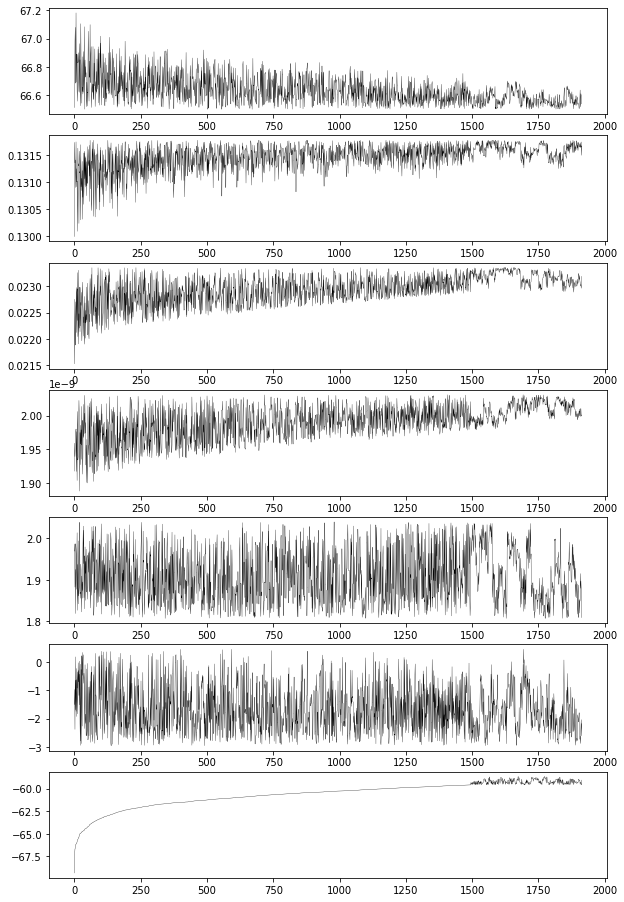

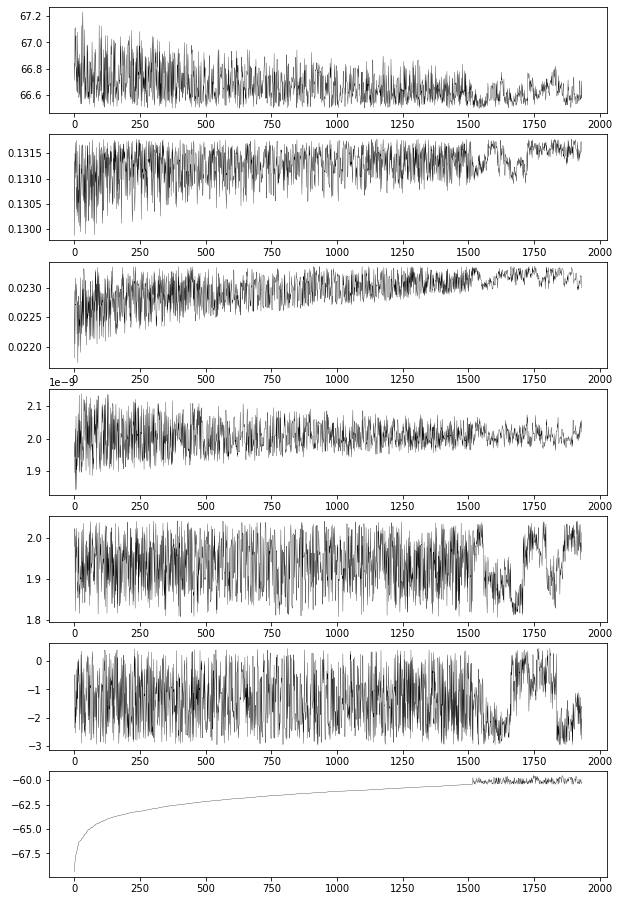

In [14]:
#import pymultinest
chains_dir = "/home/joeadamo/Research/CovNet/chains/"
prefix = ["Multinest-", "Varied-"]
parameters = ["H0", "omch2","ombh2", "As","b1","b2"]
n_params=6
# lets analyse the results
a_fixed = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[0])
a_varied = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[1])
#s = a.get_stats()

chain_fixed = a_fixed.get_equal_weighted_posterior()
chain_varied = a_varied.get_equal_weighted_posterior()

chain_varied[:,3] = np.exp(chain_varied[:,3]) / 1e10
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(7):
    ax[i].plot(chain_fixed[:,i].T, 'k-', lw=0.3)
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(7):
    ax[i].plot(chain_varied[:,i].T, 'k-', lw=0.3)
plt.show()  

0.022159526903999995 0.119016324756
Removed no burn in
Removed no burn in


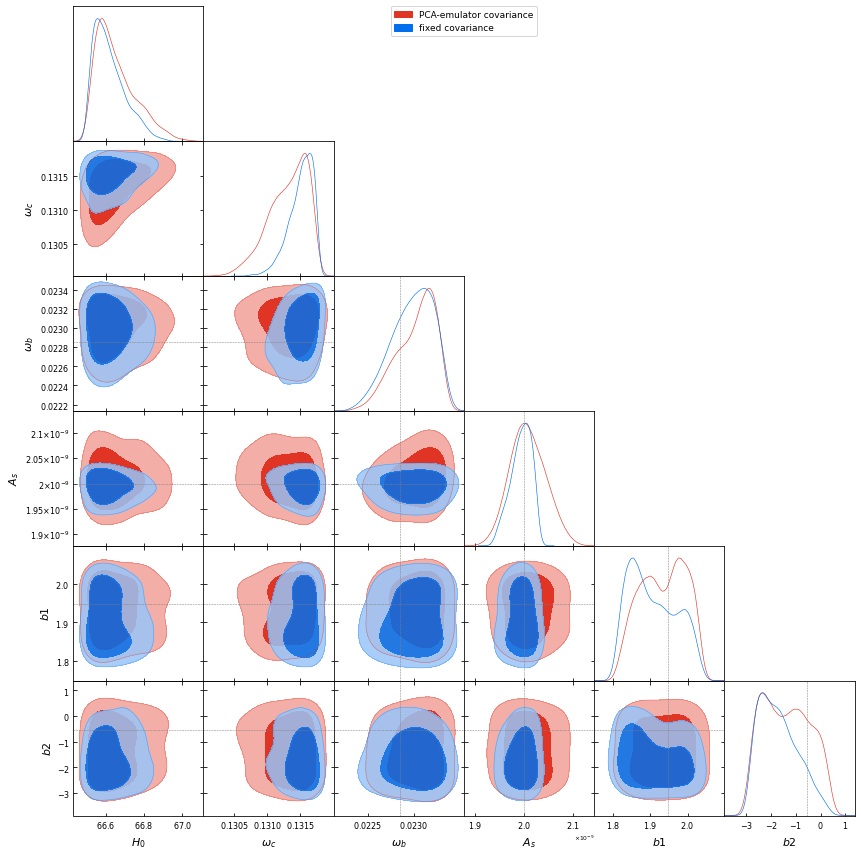

In [18]:
N_BURN_IN = 250
cosmo_truth = [67.8, 0.1190, 0.02215, 2e-9, 2.01, -0.47]
cosmo_fid = np.array([67.8, 0.1190, 0.02215, 2e-9, 2.01, -0.47])
Omega_b = 0.048206; h = cosmo_fid[0] / 100.
Omega_m = 0.307115
print(Omega_b * h**2, (Omega_m - Omega_b)*h**2)
#model the cholesky decomposition
#double check how I canclulate H0
#compare C with other emulators
#samples_fixed = chain_fixed[N_BURN_IN:, :].reshape((-1,NDIM))
samples_1 = chain_fixed[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
samples_2 = chain_varied[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
plot_cosmo_contours(samples_2, samples_1, [ "PCA-emulator covariance", 'fixed covariance'], 6)

In [ ]:
# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.
p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])

    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

plt.show()
#plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')